In [9]:
from kerastuner import RandomSearch
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Dropout
from keras.optimizers import Adam
from keras import regularizers

def build_model(hp):
    model = Sequential()
    
    # Encoder
    model.add(Conv1D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_1_kernel', values=list(range(2, 10))),
                     activation='relu',
                     padding='same',
                     kernel_regularizer=regularizers.l2(hp.Float('conv_1_l2', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-4)),
                     input_shape=(look_back, x_train.shape[-1])))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=hp.Int('conv_2_filter', min_value=16, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_2_kernel', list(range(2, 10))),
                     activation='relu',
                     padding='same'))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(LSTM(units=hp.Int('lstm_1_units', min_value=16, max_value=128, step=32),
                   return_sequences=False,
                   kernel_regularizer=regularizers.l2(hp.Float('lstm_1_l2', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-4))))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Set the desired output sequence length using RepeatVector
    model.add(RepeatVector(predict_steps))
    
    # Decoder
    model.add(LSTM(units=hp.Int('lstm_2_units', min_value=16, max_value=128, step=32),
                   return_sequences=True))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(TimeDistributed(Dense(3, activation='softmax')))
    
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model


# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='output_seq2seq_3',
    project_name='StockPricePrediction'
)

trials = tuner.oracle.trials

for trial_id, trial in trials.items():
    trial_hyperparameters = trial.hyperparameters.values
    trial_score = trial.score
    print(f"Trial {trial_id}:\nHyperparameters: {trial_hyperparameters}\nValidation Accuracy: {trial_score}\n{'='*50}")


INFO:tensorflow:Reloading Tuner from output_seq2seq_3\StockPricePrediction\tuner0.json


Trial 08:
Hyperparameters: {'conv_1_filter': 64, 'conv_1_kernel': 3, 'conv_1_l2': 9.579070050972319e-05, 'dropout_1': 0.5, 'conv_2_filter': 48, 'conv_2_kernel': 9, 'dropout_2': 0.2, 'lstm_1_units': 112, 'lstm_1_l2': 0.0016327946378896505, 'dropout_3': 0.4, 'lstm_2_units': 112, 'dropout_4': 0.5, 'learning_rate': 1e-05}
Validation Accuracy: 0.6551724076271057
Trial 06:
Hyperparameters: {'conv_1_filter': 128, 'conv_1_kernel': 5, 'conv_1_l2': 1.0534437775091327e-05, 'dropout_1': 0.1, 'conv_2_filter': 80, 'conv_2_kernel': 8, 'dropout_2': 0.1, 'lstm_1_units': 112, 'lstm_1_l2': 0.001303920933040996, 'dropout_3': 0.1, 'lstm_2_units': 48, 'dropout_4': 0.2, 'learning_rate': 0.001}
Validation Accuracy: 0.7622126340866089
Trial 04:
Hyperparameters: {'conv_1_filter': 64, 'conv_1_kernel': 6, 'conv_1_l2': 2.2976096628515046e-05, 'dropout_1': 0.2, 'conv_2_filter': 16, 'conv_2_kernel': 3, 'dropout_2': 0.5, 'lstm_1_units': 80, 'lstm_1_l2': 8.830847187133025e-05, 'dropout_3': 0.5, 'lstm_2_units': 80, 'dr

[*********************100%***********************]  1 of 1 completed


C:\Users\e4903\AppData\Local\Temp\ipykernel_3884\2500940235.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['High'] = df['Close'] + np.random.normal(0, 1, n_days)
C:\Users\e4903\AppData\Local\Temp\ipykernel_3884\2500940235.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Low'] = df['Close'] - np.random.normal(0, 1, n_days)
C:\Users\e4903\AppData\Local\Temp\ipykernel_3884\2500940235.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

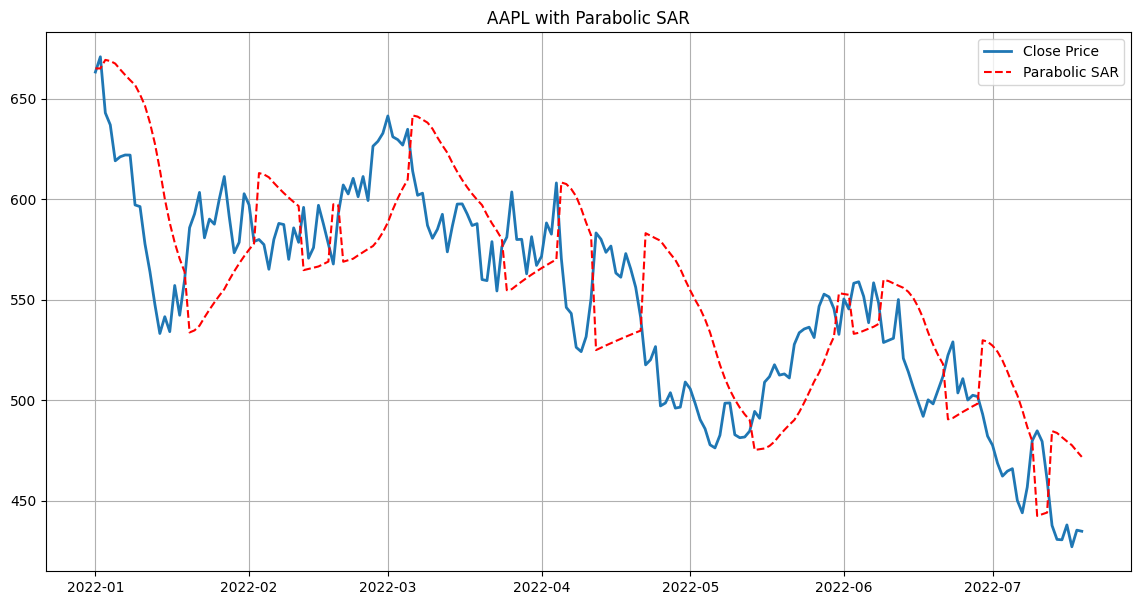

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 
# Create a simulated price data
n_days = 200
initial_price = 150

df = yf.download('AVGO', start='2022-01-01', end='2023-01-01')[:200]
# Create a DataFrame for our data
df['High'] = df['Close'] + np.random.normal(0, 1, n_days)
df['Low'] = df['Close'] - np.random.normal(0, 1, n_days)
df['Date'] = pd.date_range(start="2022-01-01", periods=n_days)
df.set_index('Date', inplace=True)

def compute_parabolic_SAR(df):
    # Initialize starting values
    initial_AF = 0.02
    max_AF = 0.2
    
    # Create SAR column and set initial value
    df['SAR'] = np.nan
    df.iloc[0, df.columns.get_loc('SAR')] = df.iloc[0]['Low']  # Start from the low of first day
    
    # Determine initial trend direction (upwards if the second day closes higher than the first day)
    uptrend = df.iloc[1]['Close'] > df.iloc[0]['Close']
    
    # Initial EP
    if uptrend:
        EP = df.iloc[0]['High']
    else:
        EP = df.iloc[0]['Low']
    
    # Main loop to compute SAR values
    for i in range(1, len(df)):
        # Calculate SAR
        if uptrend:
            df.iloc[i, df.columns.get_loc('SAR')] = df.iloc[i-1]['SAR'] + initial_AF * (EP - df.iloc[i-1]['SAR'])
        else:
            df.iloc[i, df.columns.get_loc('SAR')] = df.iloc[i-1]['SAR'] - initial_AF * (df.iloc[i-1]['SAR'] - EP)
        
        # Check for SAR switch & update EP and AF
        if uptrend:
            if df.iloc[i]['Low'] < df.iloc[i]['SAR']:
                uptrend = False
                df.iloc[i, df.columns.get_loc('SAR')] = EP
                EP = df.iloc[i]['Low']
                initial_AF = 0.02
            else:
                if df.iloc[i]['High'] > EP:
                    EP = df.iloc[i]['High']
                    initial_AF = min(initial_AF + 0.02, max_AF)
        else:
            if df.iloc[i]['High'] > df.iloc[i]['SAR']:
                uptrend = True
                df.iloc[i, df.columns.get_loc('SAR')] = EP
                EP = df.iloc[i]['High']
                initial_AF = 0.02
            else:
                if df.iloc[i]['Low'] < EP:
                    EP = df.iloc[i]['Low']
                    initial_AF = min(initial_AF + 0.02, max_AF)

    return df

df = compute_parabolic_SAR(df)

# Plotting the data
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price', linewidth=2)
plt.plot(df['SAR'], label='Parabolic SAR', linestyle='--', color='red')
plt.title('AAPL with Parabolic SAR')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\e4903\AppData\Local\Temp\ipykernel_3884\1446015817.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Portfolio_Value'] = portfolio_value
C:\Users\e4903\AppData\Local\Temp\ipykernel_3884\1446015817.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Returns'] = df['Portfolio_Value'].pct_change()
C:\Users\e4903\AppData\Local\Temp\ipykernel_3884\1446015817.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

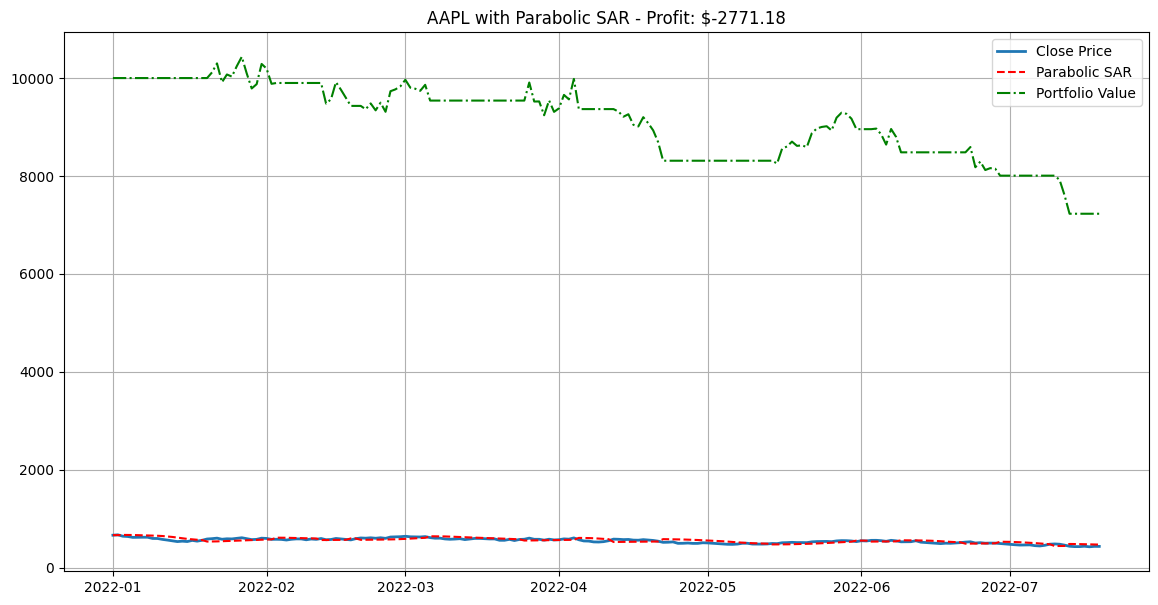

In [48]:
def simulate_trading_with_SAR_updated(df):
    initial_cash = 10000  # Starting cash
    cash = initial_cash
    stocks = 0
    portfolio_value = [initial_cash]

    uptrend = df.iloc[1]['Close'] > df.iloc[0]['Close']
    for i in range(1, len(df)):
        # Check for trading signals
        if uptrend and df.iloc[i]['Low'] < df.iloc[i]['SAR']:
            # Sell Signal: SAR switched from below price to above
            cash += stocks * df.iloc[i]['Close']
            stocks = 0
            uptrend = False
        elif not uptrend and df.iloc[i]['High'] > df.iloc[i]['SAR']:
            # Buy Signal: SAR switched from above price to below
            stocks += cash / df.iloc[i]['Close']
            cash = 0
            uptrend = True
        
        portfolio_value.append(cash + stocks * df.iloc[i]['Close'])

    df['Portfolio_Value'] = portfolio_value
    df['Returns'] = df['Portfolio_Value'].pct_change()
    df['Cumulative_Returns'] = (1 + df['Returns']).cumprod() - 1

    return df, df.iloc[-1]['Portfolio_Value'] - initial_cash

df, profit = simulate_trading_with_SAR_updated(df)

# Plotting the data
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price', linewidth=2)
plt.plot(df['SAR'], label='Parabolic SAR', linestyle='--', color='red')
plt.plot(df['Portfolio_Value'], label='Portfolio Value', linestyle='-.', color='green')
plt.title(f'AAPL with Parabolic SAR - Profit: ${profit:.2f}')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\e4903\AppData\Local\Temp\ipykernel_3884\124653229.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Portfolio_Value_Shorting'] = portfolio_value
C:\Users\e4903\AppData\Local\Temp\ipykernel_3884\124653229.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Returns_Shorting'] = df['Portfolio_Value_Shorting'].pct_change()
C:\Users\e4903\AppData\Local\Temp\ipykernel_3884\124653229.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

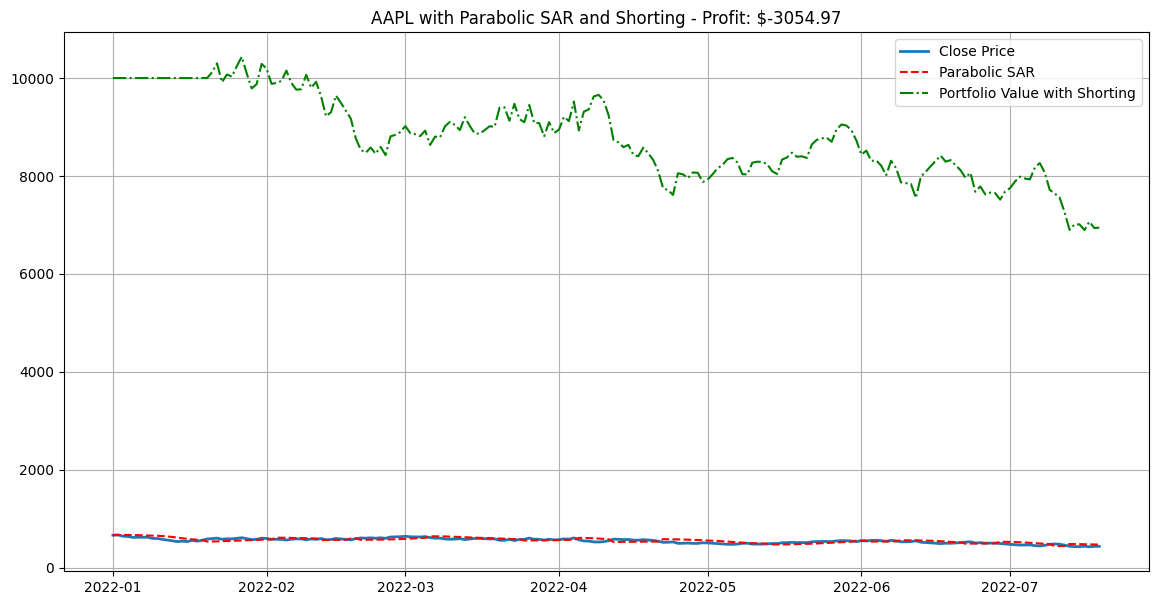

In [49]:
def simulate_trading_with_shorting(df):
    initial_cash = 10000  # Starting cash
    cash = initial_cash
    stocks = 0
    portfolio_value = [initial_cash]

    uptrend = df.iloc[1]['Close'] > df.iloc[0]['Close']
    for i in range(1, len(df)):
        # Check for trading signals
        if uptrend and df.iloc[i]['Low'] < df.iloc[i]['SAR']:
            # Sell Signal: SAR switched from below price to above
            cash += 2 * stocks * df.iloc[i]['Close']  # Selling current stocks and shorting the same amount
            stocks = -stocks  # Now we have shorted the stocks
            uptrend = False
        elif not uptrend and df.iloc[i]['High'] > df.iloc[i]['SAR']:
            # Buy Signal: SAR switched from above price to below
            stocks += cash / df.iloc[i]['Close']
            cash = 0
            uptrend = True
        
        portfolio_value.append(cash + stocks * df.iloc[i]['Close'])

    df['Portfolio_Value_Shorting'] = portfolio_value
    df['Returns_Shorting'] = df['Portfolio_Value_Shorting'].pct_change()
    df['Cumulative_Returns_Shorting'] = (1 + df['Returns_Shorting']).cumprod() - 1

    return df, df.iloc[-1]['Portfolio_Value_Shorting'] - initial_cash

df, profit_with_shorting = simulate_trading_with_shorting(df)

# Plotting the data
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price', linewidth=2)
plt.plot(df['SAR'], label='Parabolic SAR', linestyle='--', color='red')
plt.plot(df['Portfolio_Value_Shorting'], label='Portfolio Value with Shorting', linestyle='-.', color='green')
plt.title(f'AAPL with Parabolic SAR and Shorting - Profit: ${profit_with_shorting:.2f}')
plt.legend()
plt.grid(True)
plt.show()
